## Question 1

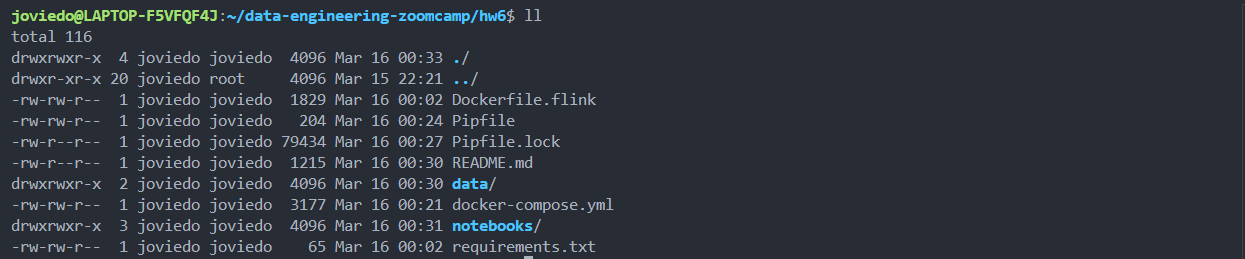

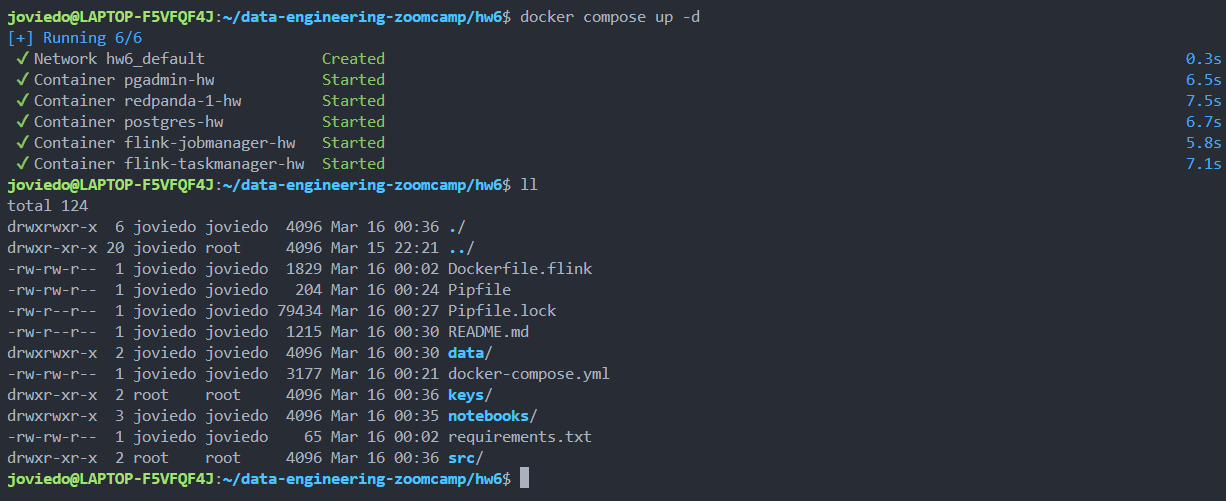

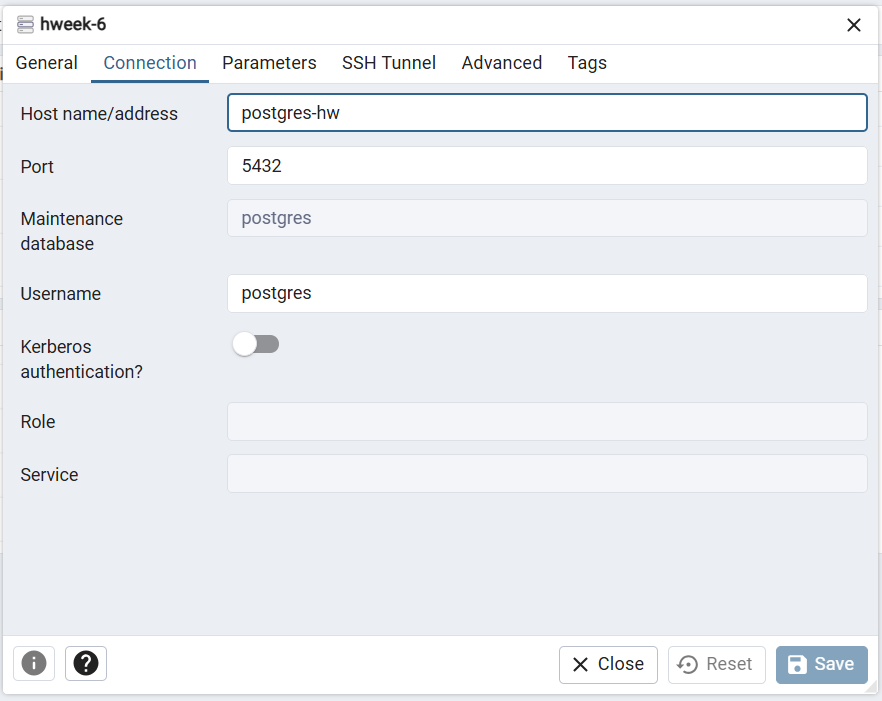

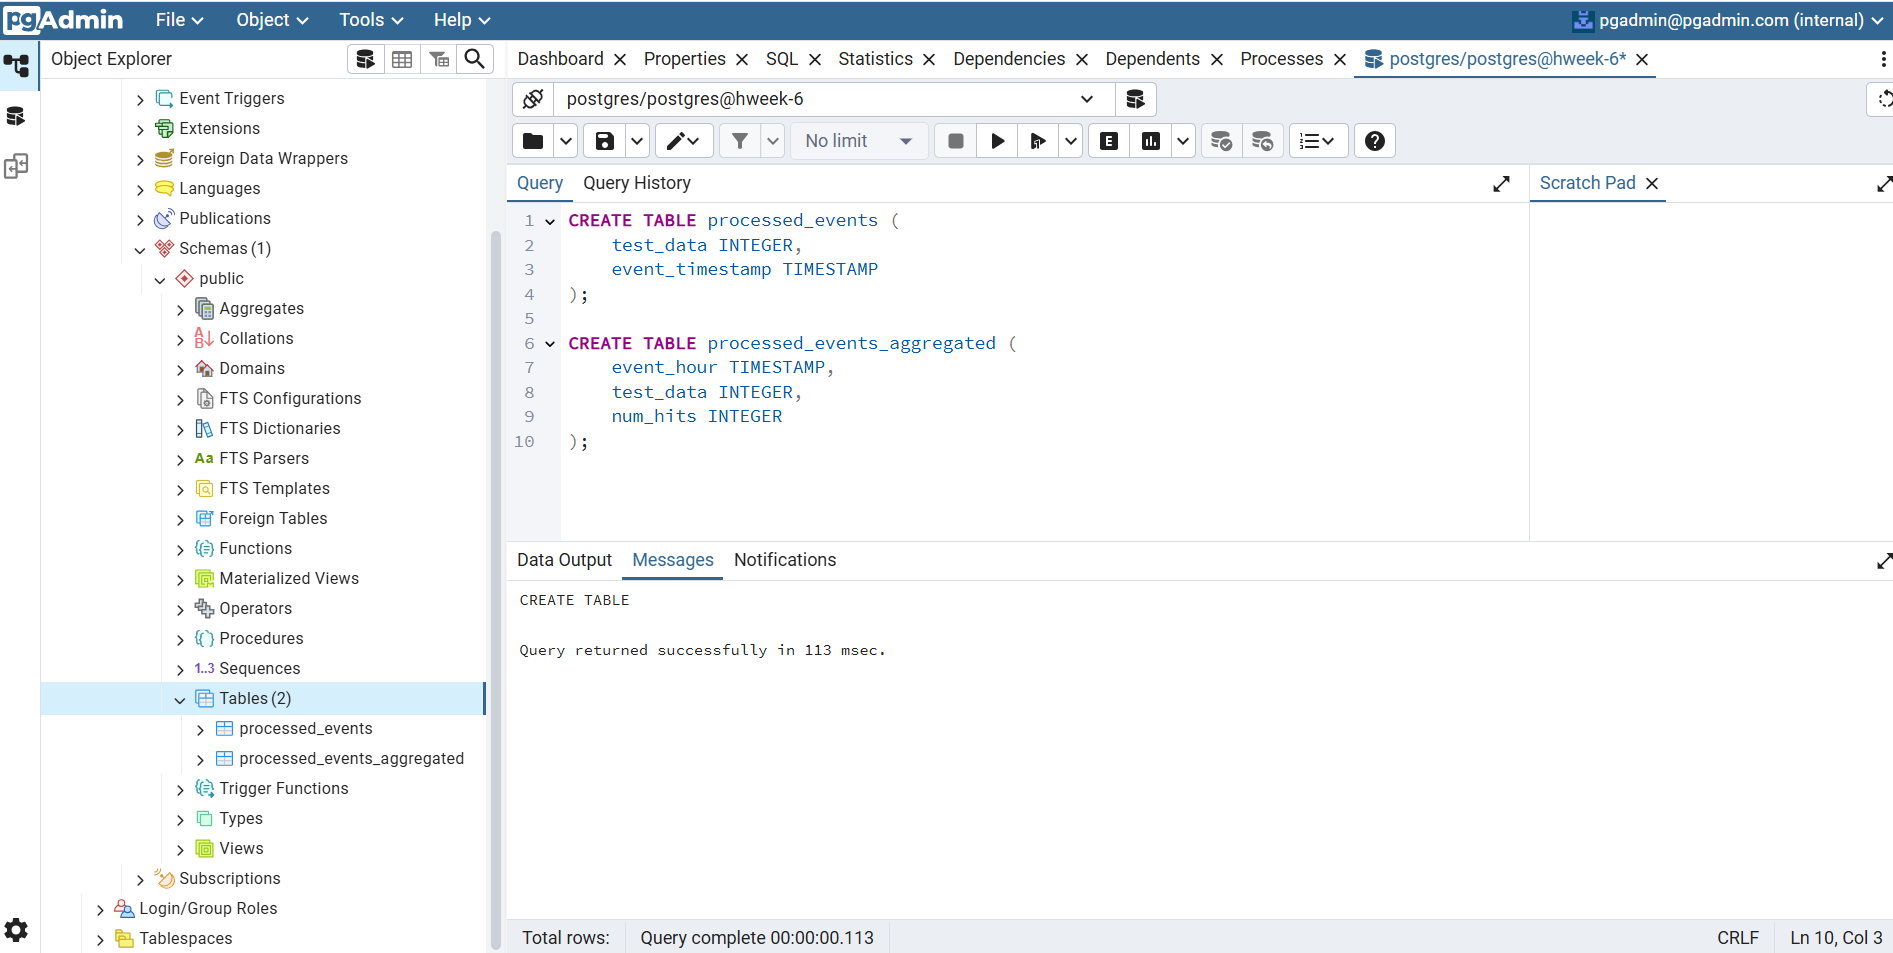

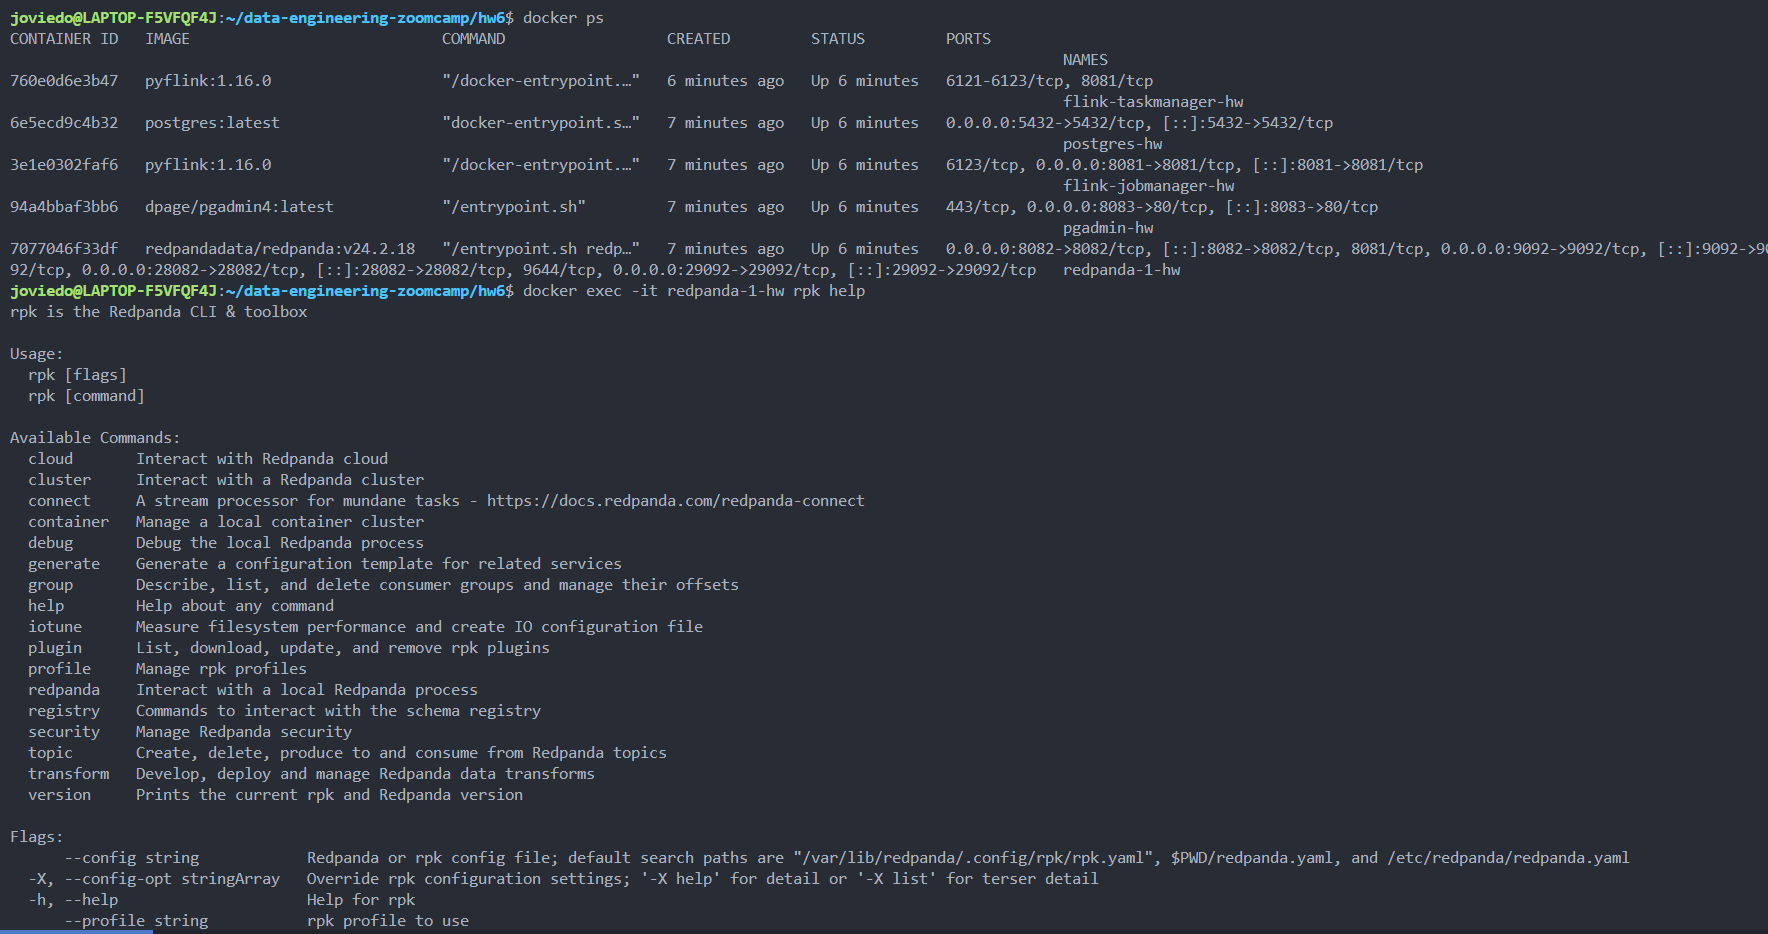

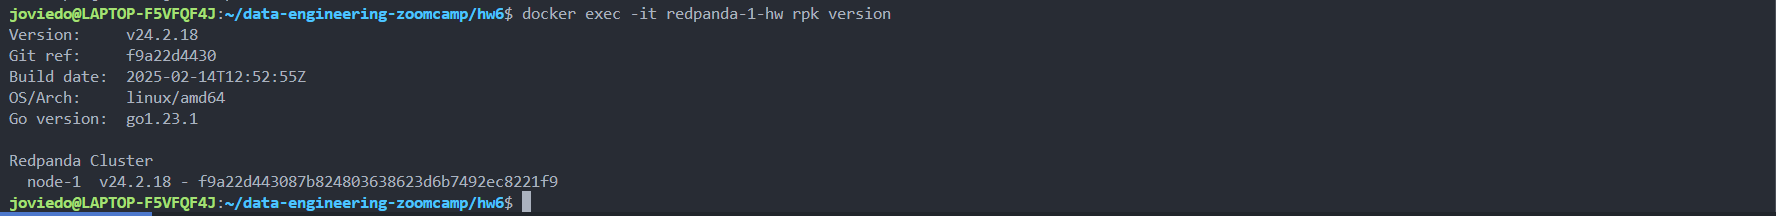

## Question 2

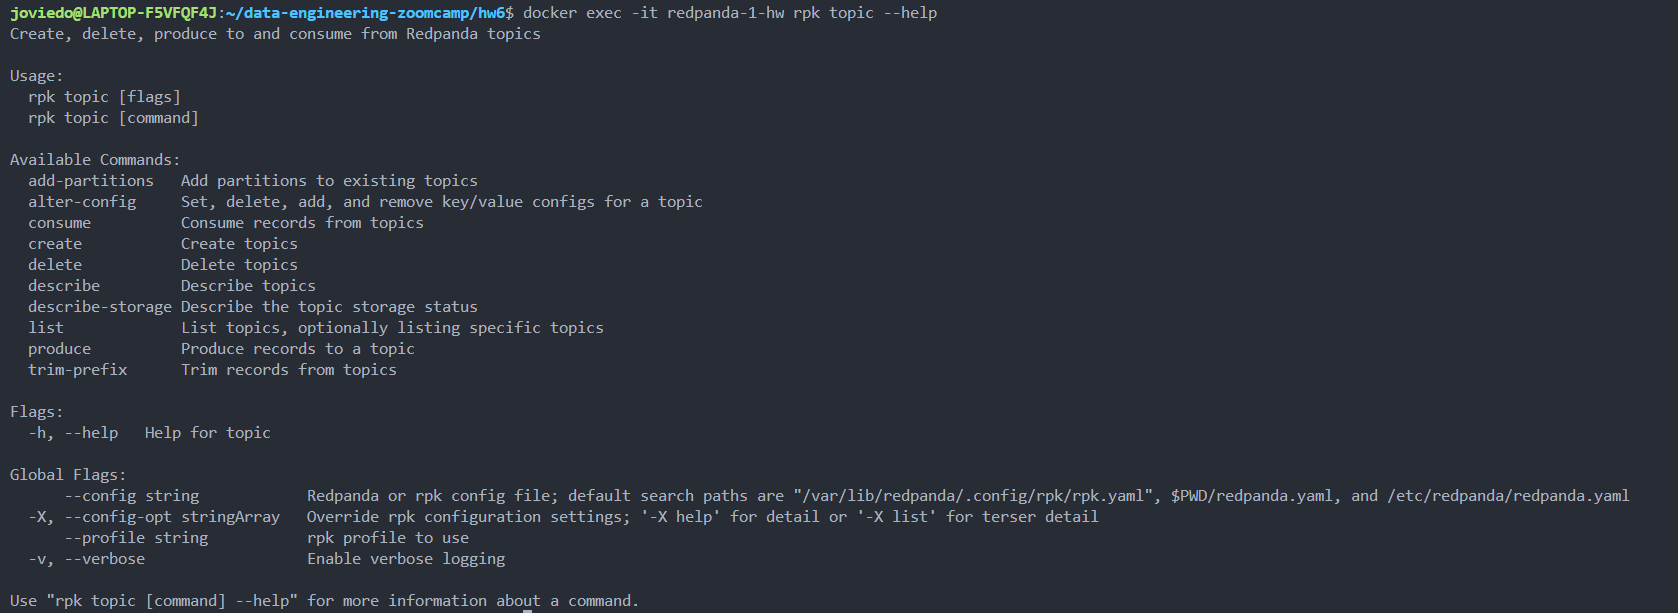

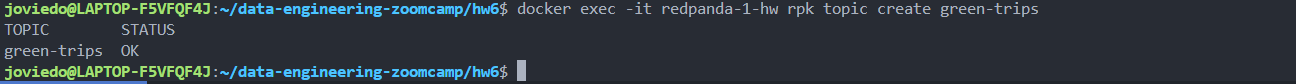

## Question 3

In [2]:
!mkdir -p ../src/producers

In [5]:
!ls ../src

producers


In [6]:
!touch ../src/producers/producers_hw.py

In [7]:
!ls ../src/producers

producers_hw.py


**Copiar el siguiente codigo al script de python `producers_hw.py` y ejecutar el script**

```python
import json

from kafka import KafkaProducer

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

server = 'localhost:9092'

producer = KafkaProducer(
    bootstrap_servers=[server],
    value_serializer=json_serializer
)

result = producer.bootstrap_connected()
print(result)
```

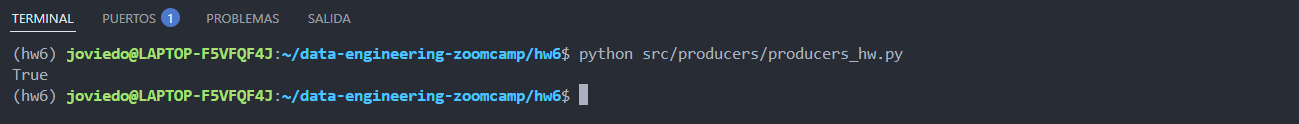

**Tambien lo podemos ejecutar desde este cuaderno de jupyter **

In [11]:
import json

from kafka import KafkaProducer

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

server = 'localhost:9092'

producer = KafkaProducer(
    bootstrap_servers=[server],
    value_serializer=json_serializer
)

producer.bootstrap_connected()

True

## Question 4

In [12]:
import pandas as pd

df_green_data = pd.read_csv("../data/green_tripdata_2019-10.csv")

df_green_data.shape

/tmp/ipykernel_2528/3468711861.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_green_data = pd.read_csv("../data/green_tripdata_2019-10.csv")


(476386, 20)

Para optimizar el uso de memoria, es recomendable leer el archivo en porciones (chunks) y aprovechar los hilos de la CPU para realizar en paralelo la lectura y el envío de datos, evitando así cargar todo el archivo en memoria de una sola vez.

Se modifico el script `producers_hw.py` quedando de la siguiente manera:

```python
import json
import pandas as pd
import time
import concurrent.futures
import threading
from kafka import KafkaProducer

MAX_WORKERS = 64
CHUNKSIZE = 2500
TOPIC_NAME = "green-trips" 
producer = None

def json_serializer(data):
    return json.dumps(data).encode('utf-8')


def init_producer():
    global producer
    server = 'localhost:9092'

    producer = KafkaProducer(
        bootstrap_servers=[server],
        value_serializer=json_serializer
    )

    return producer.bootstrap_connected()


def sent_data(data_raw, chunk_number):
    thread_id = threading.current_thread().name
    print(f"[Thread {thread_id}] - Enviando chunk número {chunk_number} con {len(data_raw)} registros...")

    for message in data_raw:
        producer.send(TOPIC_NAME, value=message)
        time.sleep(0.05)

    producer.flush()
    print(f"[Thread {thread_id}] - Finalizó envío del chunk número {chunk_number}.")


def get_data_raw():
    
    columns = ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'tip_amount']
    topic_name = "green-trips"

    t0 = time.time()      
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []

        for idx, chunk in enumerate(pd.read_csv("../../data/green_tripdata_2019-10.csv", chunksize=CHUNKSIZE)):
            chunk = chunk[columns]
            chunk.loc[:, columns[4]] = chunk[columns[4]].fillna(0)
            data_dict = chunk.to_dict(orient='records')
            futures.append(executor.submit(sent_data, data_dict, idx + 1))
        
        concurrent.futures.wait(futures)

    t1 = time.time()
    took = t1 - t0
    print(f"\nTiempo total de ejecución: {took:.2f} segundos")


if __name__ == '__main__':

    if init_producer():
        get_data_raw()
```

Los valores de `MAX_WORKERS` y `CHUNKSIZE` deben ajustarse de manera equilibrada para evitar la sobresaturación de los recursos de la computadora y asegurar un rendimiento eficiente.

En mi caso, al contar con una computadora con 8 hilos lógicos y 32 GB de RAM, utilicé los siguientes valores: `CHUNKSIZE = 2500` y `MAX_WORKERS = 64`. Estos parámetros fueron seleccionados para lograr un equilibrio entre el tamaño de cada porción de datos leída y el número de hilos en paralelo, asegurando un buen rendimiento sin saturar los recursos del equipo.

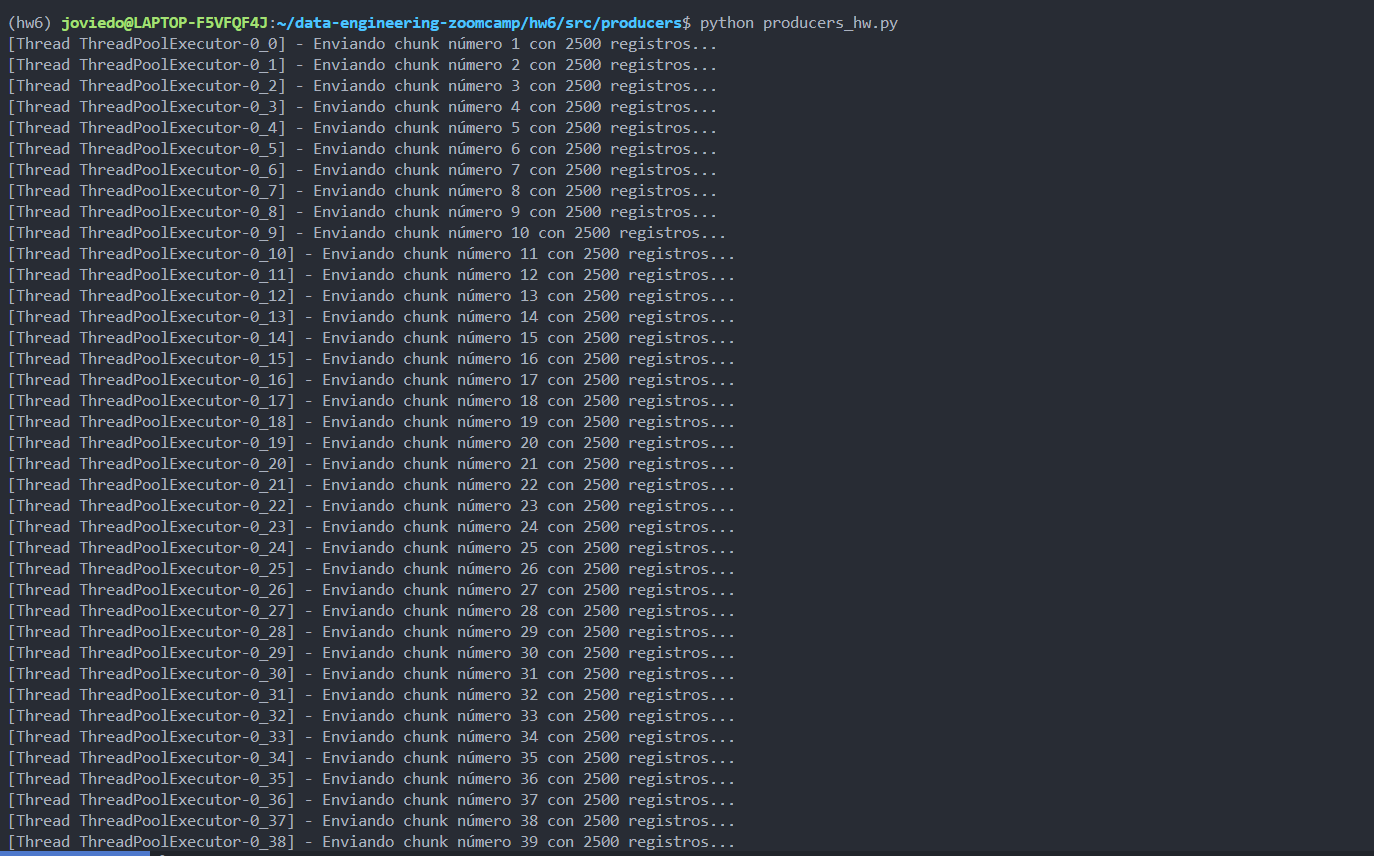

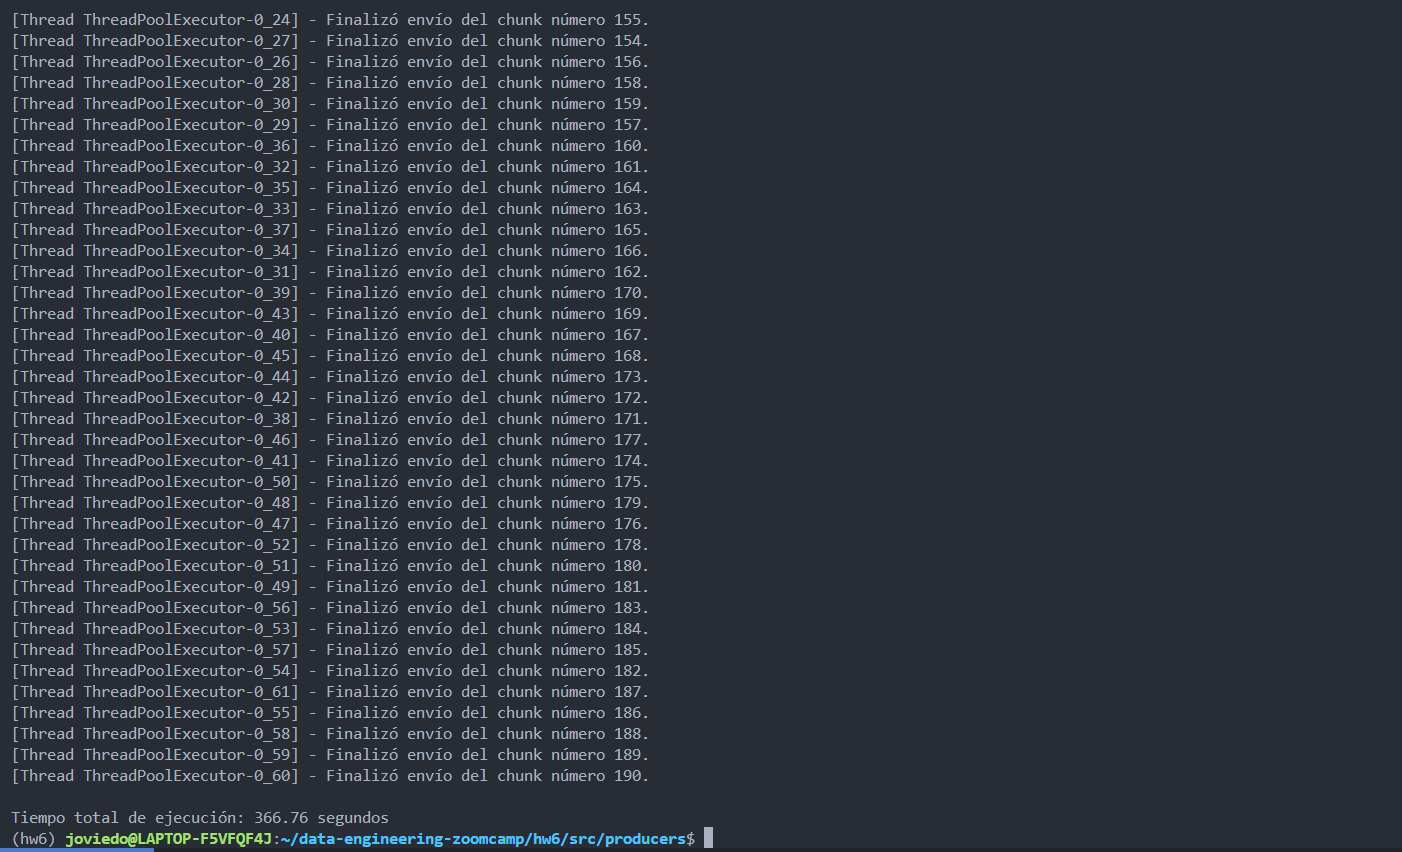

## Question 5

Ejecuta la siguiente instrucción en PostgreSQL:

```sql
DROP TABLE processed_events_aggregated;

CREATE TABLE processed_events_aggregated
(
	PULocationID integer,
	DOLocationID integer,
	session_start timestamp(3),
	session_end timestamp(3),
	num_trips BIGINT,
	PRIMARY KEY (PULocationID, DOLocationID, session_start)
);
```

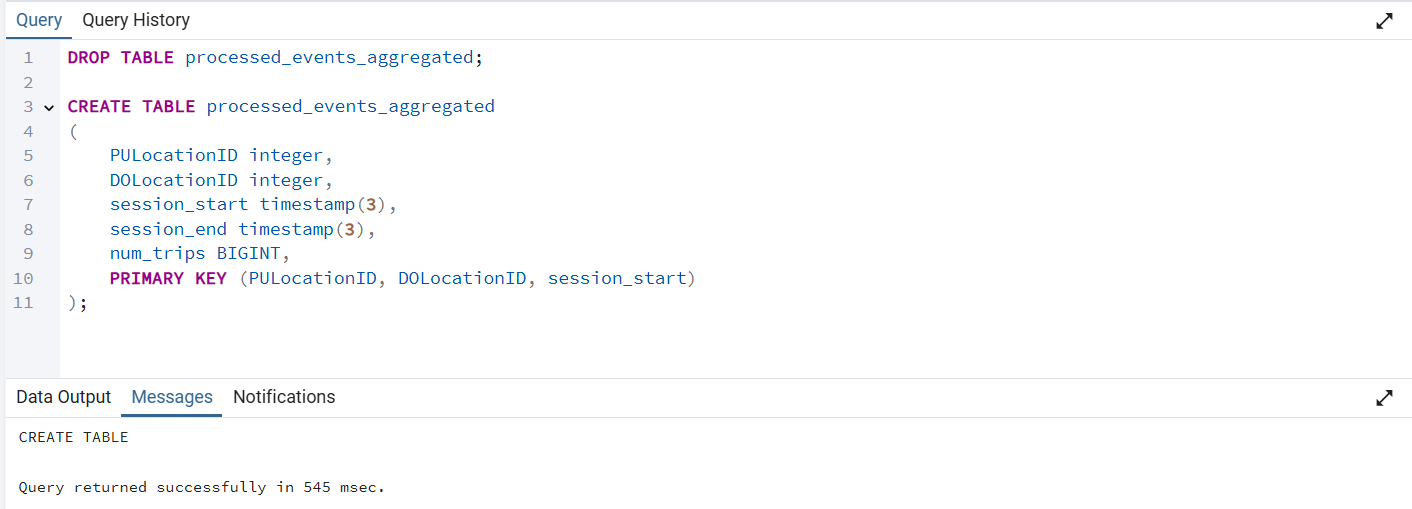

In [14]:
!mkdir -p ../src/job

In [15]:
!ls ../src

job  producers


In [16]:
!touch ../src/job/session_job.py

Se modifico el script `session_job.py` quedando de la siguiente manera:

```python
from pyflink.datastream import StreamExecutionEnvironment
from pyflink.table import EnvironmentSettings, StreamTableEnvironment
from pyflink.common.watermark_strategy import WatermarkStrategy
from pyflink.common.time import Duration
from pyflink.table.window import Session
from pyflink.table.expressions import col, lit

def create_events_aggregated_sink(t_env):
    table_name = 'processed_events_aggregated'
    sink_ddl = f"""
        CREATE TABLE {table_name} (
            pulocationid integer,
            dolocationid integer,
            session_start timestamp(3),
            session_end timestamp(3),
            num_trips BIGINT,
            PRIMARY KEY (pulocationid, dolocationid, session_start) NOT ENFORCED
        ) WITH (
            'connector' = 'jdbc',
            'url' = 'jdbc:postgresql://postgres-hw:5432/postgres',
            'table-name' = '{table_name}',
            'username' = 'postgres',
            'password' = 'postgres',
            'driver' = 'org.postgresql.Driver'
        );
        """
    t_env.execute_sql(sink_ddl)
    return table_name


def create_events_source_kafka(t_env):
    table_name = "events_green_trips"
    source_ddl = f"""
        CREATE TABLE {table_name} (
            lpep_pickup_datetime timestamp(3),
            lpep_dropoff_datetime timestamp(3),
            PULocationID integer,
            DOLocationID integer,
            passenger_count integer,
            trip_distance double,
            tip_amount double,
            WATERMARK FOR lpep_dropoff_datetime AS lpep_dropoff_datetime - INTERVAL '5' SECOND
        ) WITH (
            'connector' = 'kafka',
            'properties.bootstrap.servers' = 'redpanda-1-hw:29092',
            'topic' = 'green-trips',
            'scan.startup.mode' = 'earliest-offset',
            'properties.auto.offset.reset' = 'earliest',
            'format' = 'json'
        );
        """
    t_env.execute_sql(source_ddl)
    return table_name


def log_aggregation():
    env = StreamExecutionEnvironment.get_execution_environment()
    env.enable_checkpointing(60 * 1000)
    env.set_parallelism(1)

    settings = EnvironmentSettings.new_instance().in_streaming_mode().build()
    t_env = StreamTableEnvironment.create(env, environment_settings=settings)

    watermark_strategy = (
        WatermarkStrategy
        .for_bounded_out_of_orderness(Duration.of_seconds(5))
        .with_timestamp_assigner(
            lambda event, timestamp: event['lpep_dropoff_datetime']
        )
    )
    try:
        source_table = create_events_source_kafka(t_env)
        aggregated_table = create_events_aggregated_sink(t_env)

        table = t_env.from_path(source_table)

        session_window = table.window(Session.with_gap(lit(5).minutes)\
                                    .on(col('lpep_dropoff_datetime'))\
                                    .alias('session'))

        result = session_window.group_by(col('PULocationID'), col('DOLocationID'), col('session'))\
                                .select(col('PULocationID').alias('pulocationid')\
                                    ,col('DOLocationID').alias('dolocationid')\
                                    ,col('session').start.alias('session_start')\
                                    ,col('session').end.alias('session_end')\
                                    ,col('PULocationID').count.alias('num_trips'))

        result.execute_insert(aggregated_table).wait()

    except Exception as e:
        print("Writing records from Kafka to JDBC failed:", str(e))


if __name__ == '__main__':
    log_aggregation()
```

Ejecutar el siguiente comando:

```bash
docker compose exec jobmanager-hw ./bin/flink run -py /opt/src/job/session_job.py --pyFiles /opt/src -d
```

Ejecuta la siguiente instrucción en PostgreSQL:

```sql
SELECT * FROM public.processed_events_aggregated
ORDER BY num_trips DESC;
```

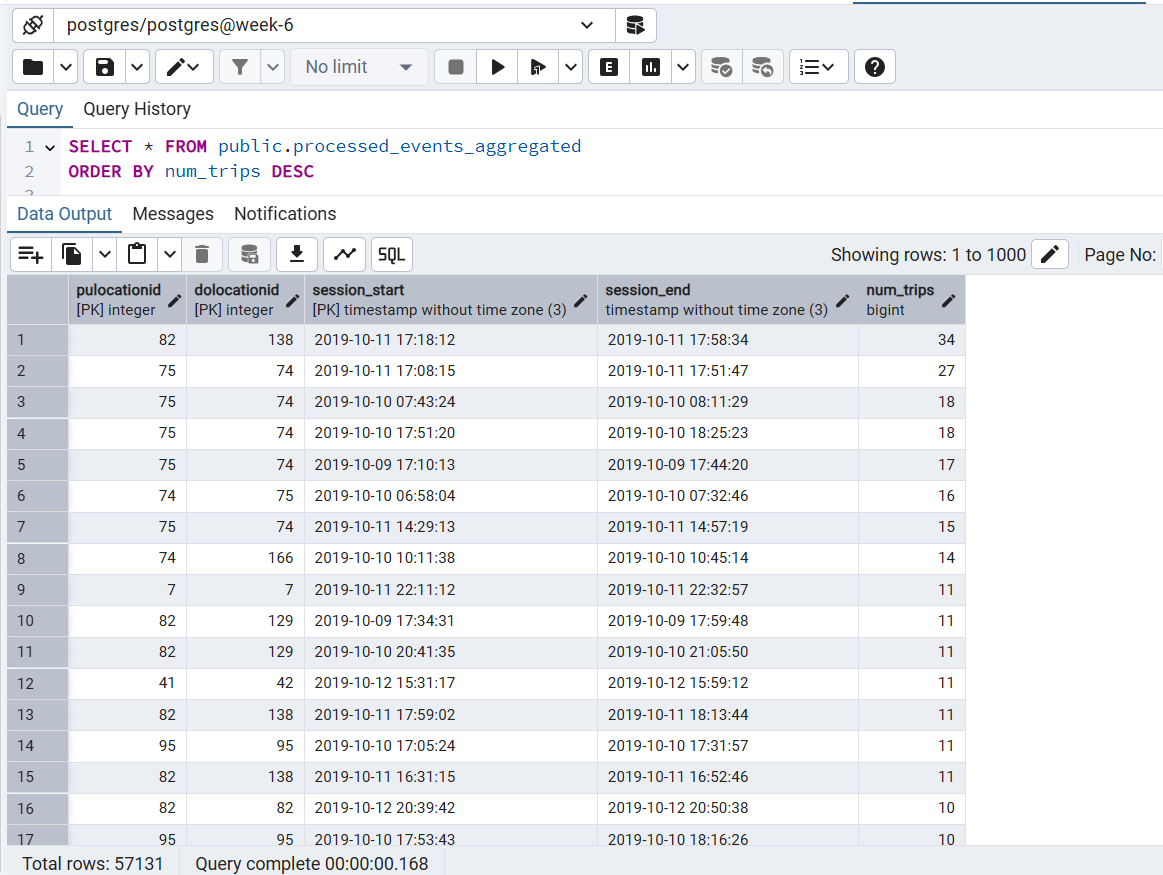